In [78]:
%matplotlib inline
import cmath
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import csv
from datetime import datetime

In [2]:
# Define functions which work with transmission matrix
def generate_tm_vec(sigma, size):
    """Generate a single vector of a transmission matrix."""
    # The transmission vector is normalized according to Vellekoop thesis (p. 93).
    # Normalization factor is 1 / sqrt(size). Additional factor 1 / sqrt(2) appears
    # due to construction of the transmission vector of two Normal random numbers.
    return (np.random.normal(loc=0.0, scale=sigma, size=size) +
        1j * np.random.normal(loc=0.0, scale=sigma, size=size)) / np.sqrt(2.0 * size)

def tm_vec_add_noise(tm_vec, sigma_noise, sigma_signal):
    # Addition of noise is made according to Vellekoop thesis (p. 94). The
    # transmission vector is normalized as shown in the fromula (7.8).
    # t_mn -> (t_mn + xi) / sqrt(1 + (sigma_noise / sigma_signal)^2)
    noise_vec = ((np.random.normal(loc=0.0, scale=sigma_noise, size=len(tm_vec)) +
                 1j * np.random.normal(loc=0.0, scale=sigma_noise, size=len(tm_vec)))
                 / np.sqrt(2.0 * len(tm_vec)))
    result_vec = (tm_vec + noise_vec) / np.sqrt(1.0 + (sigma_noise / sigma_signal)**2)
    return result_vec

In [72]:
# Define algorithm functions
def optimize_csa(tm_vec,
                 initial_slm_pattern, # ndarray
                 initial_enh_history, # ndarray
                 initial_intensity: float,
                 start_step: int,
                 steps_num: int,
                 slm_size: int,
                 noise_func, # typing.Callable[[ndarray], ndarray]
                 use_noised_tm: bool,
                 inc_el_field):

    if initial_enh_history is None:
        enh_history_csa = np.zeros(steps_num, dtype=np.float64)
    else:
        enh_history_csa = initial_enh_history[:]

    if initial_slm_pattern is None:
        slm_pattern_csa = np.ones(slm_size, dtype=np.float64)
    else:
        slm_pattern_csa = initial_slm_pattern[:]
    
    if start_step != None:
        s_step = start_step
        slm_pos = s_step % slm_size
    else:
        s_step = 0
        slm_pos = 0

    tm_vec_var_csa = tm_vec.copy()
    for i in range(s_step, steps_num):
        # 1. Add noise if required
        if noise_func != None:
            if use_noised_tm:
                tm_vec_var_csa = noise_func(tm_vec_var_csa)
            else:
                tm_vec_var_csa = noise_func(tm_vec)
        # 2. Measure intensity
        i_before = np.abs(np.dot(tm_vec_var_csa, slm_pattern_csa) * inc_el_field)**2
        # 3. Switch SLM pixel state
        slm_pattern_csa[slm_pos] = 1.0 - slm_pattern_csa[slm_pos]
        # 4. Add noise if required
        if noise_func != None:
            if use_noised_tm:
                tm_vec_var_csa = noise_func(tm_vec_var_csa)
            else:
                tm_vec_var_csa = noise_func(tm_vec)
        # 6. Measure intensity
        i_after = np.abs(np.dot(tm_vec_var_csa, slm_pattern_csa) * inc_el_field)**2
        # 7. Make a decision
        if i_after < i_before:
            slm_pattern_csa[slm_pos] = 1.0 - slm_pattern_csa[slm_pos]
            # Add the record to the list
            enh_history_csa[i] += i_before / initial_intensity
        else:
            # Add the record to the list
            enh_history_csa[i] += i_after / initial_intensity
        slm_pos += 1
        if slm_pos == slm_size:
            slm_pos = 0
    result = {
        "slm_pattern": slm_pattern_csa,
        "enh_history": enh_history_csa,
        "tm_vec": tm_vec_var_csa
    }
    return result

def optimize_hadamard(tm_vec,
                      initial_enh_history,
                      initial_intensity: float,
                      steps_num: int,
                      slm_size: int,
                      noise_func, # typing.Callable[[ndarray], ndarray]
                      use_noised_tm: bool,
                      inc_el_field):
    h_matrix = scipy.linalg.hadamard(slm_size)   # Hadamard matrix
    h1_indices = np.fromiter((k for k in range(0, slm_size)), dtype=int)
    h_1 = h_matrix.take(indices=h1_indices)
    I_1 = np.abs(np.dot(tm_vec, h_1))**2
    
    if initial_enh_history is None:
        enh_history = np.zeros(steps_num, dtype=np.float64)
    else:
        enh_history = initial_enh_history[:]
    re_signal = np.zeros(slm_size, dtype=np.float64)
    tm_vec_est = np.zeros(slm_size, dtype=np.float64)
    slm_pattern = np.zeros(slm_size, dtype=np.float64)
    
    # Transmission matrix estimation
    tm_vec_var = tm_vec.copy()
    for slm_pix in range(0, slm_size):
        h_indices = np.fromiter((k + slm_pix * slm_size for k in range(0, slm_size)), dtype=int)
        h_i = h_matrix.take(indices=h_indices)
        v_plus = (h_1 + h_i) / 2.0
        v_minus = (h_1 - h_i) / 2.0
        if noise_func != None:
            if use_noised_tm:
                tm_vec_var = noise_func(tm_vec_var)
            else:
                tm_vec_var = noise_func(tm_vec)
        I_plus = np.abs(np.dot(tm_vec_var, v_plus) * inc_el_field)**2
        if noise_func != None:
            if use_noised_tm:
                tm_vec_var = noise_func(tm_vec_var)
            else:
                tm_vec_var = noise_func(tm_vec)
        I_minus = np.abs(np.dot(tm_vec_var, v_minus) * inc_el_field)**2
        re_signal[slm_pix] = (I_plus - I_minus) / np.sqrt(I_1)

    if not use_noised_tm:
        tm_vec_var = tm_vec.copy()

    for i in range(0, slm_size):
        h_indices = np.fromiter((k + i * slm_size for k in range(0, slm_size)), dtype=int)
        h_i = h_matrix.take(indices=h_indices)
        tm_vec_est += re_signal[i] * h_i / slm_size

    # Estimate the optimal SLM pattern
    # opened_pixels = 0
    for i in range(0, slm_size):
        if tm_vec_est[i] >= 0.0:
            slm_pattern[i] = 1.0
            # opened_pixels += 1
    
    enh_history[slm_size - 1] = np.abs(np.dot(tm_vec_var, slm_pattern) * inc_el_field)**2 / initial_intensity

    correct_estimations = 0
    for i in range(0, slm_size):
        if np.sign(tm_vec_est[i]) == np.sign(tm_vec_var[i].real):
            correct_estimations += 1
    
    for i in range(slm_size, steps_num):
        if noise_func != None:
            if use_noised_tm:
                tm_vec_var = noise_func(tm_vec_var)
            else:
                tm_vec_var = noise_func(tm_vec)
        enh_history[i] = np.abs(np.dot(tm_vec_var, slm_pattern) * inc_el_field)**2 / initial_intensity
    
    result = {
        "slm_pattern": slm_pattern,
        "enh_history": enh_history,
        "tm_vec_est": tm_vec_est,
        "tm_vec": tm_vec_var,
        "tm_correct_estimations": correct_estimations
    }
    
    return result

Initial intensity: 0.4983838628204317
Initial simulation parameters:
    slm_size           = 1024
    total_steps        = 10240
    tm_vec_sigma       = 1.0
    e_in               = (1+0j)
    simulations_number = 10
    I_init             = 0.4983838628204317

Pure Hadamard matrix algorithm. Transmission matrix entries fluctuate around the initial positions.


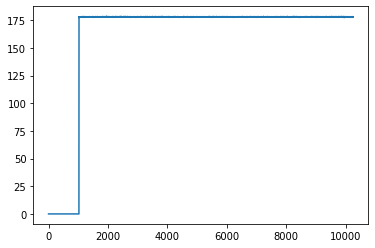

Pure Hadamard matrix algorithm. Transmission matrix entries slowly change.


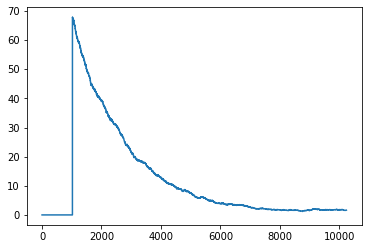

Hadamadr matrix + contineous sequential algorithm. Transmission matrix entries fluctuate around the initial positions.


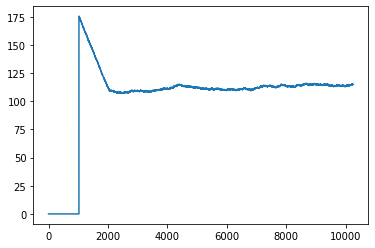

Hadamadr matrix + contineous sequential algorithm. Transmission matrix entries slowly change.


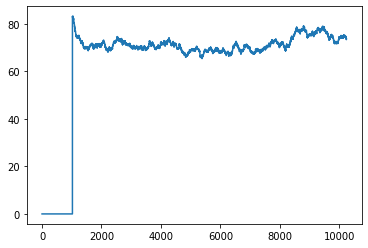

Contineous sequential algorithm. Transmission matrix entries fluctuate around the initial positions.


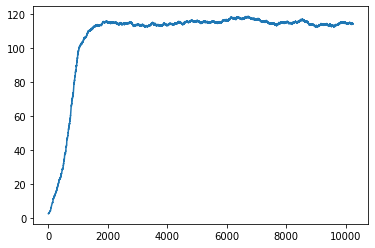

Hadamadr matrix + contineous sequential algorithm. Transmission matrix entries slowly change.


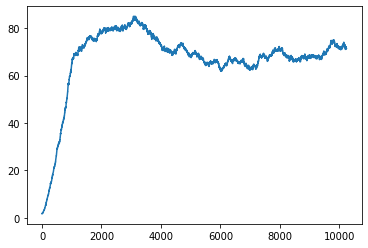

In [75]:
# Simulation parameters
slm_side = 32
slm_size = slm_side**2
total_steps = 10240
tm_vec_sigma = 1.0
e_in = 1.0 + 0.0j
use_noised_tm = False
simulations_number = 10

# Noise functions
def add_noise_1(tm_vec):
    return tm_vec_add_noise(tm_vec, 0.025, tm_vec_sigma)
def add_noise_2(tm_vec):
    return tm_vec_add_noise(tm_vec, 0.050, tm_vec_sigma)

# Calculate initial enhancement
samples_num = 100000
I_init = 0.0
slm_pattern_ref = np.ones(slm_size)
for i in range(0, samples_num):
    tm_vec_temp = generate_tm_vec(tm_vec_sigma, slm_size)
    I_init += np.abs(np.dot(tm_vec_temp, slm_pattern_ref) * e_in)**2
del tm_vec_temp
I_init = I_init / samples_num / 2.0

print("Initial intensity: {0}".format(I_init))

# # Generate transmission matrix for optimization
# tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
# e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
# align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
# tm_vec = tm_vec * align_multiplier

print("Initial simulation parameters:")
print("    slm_size           = {0}".format(slm_size))
print("    total_steps        = {0}".format(total_steps))
print("    tm_vec_sigma       = {0}".format(tm_vec_sigma))
print("    e_in               = {0}".format(e_in))
print("    simulations_number = {0}".format(simulations_number))
print("    I_init             = {0}".format(I_init))

print("")

print("Pure Hadamard matrix algorithm. Transmission matrix entries fluctuate around the initial positions.")
average_enh_history = np.zeros(total_steps)
for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    result = optimize_hadamard(tm_vec,
        initial_enh_history=None,
        initial_intensity=I_init,
        steps_num=total_steps,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=False,
        inc_el_field=e_in)
    average_enh_history += result["enh_history"]
average_enh_history /= simulations_number
    
plt.plot(average_enh_history)
plt.show()   

print("Pure Hadamard matrix algorithm. Transmission matrix entries slowly change.")
average_enh_history = np.zeros(total_steps)
for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    result = optimize_hadamard(tm_vec,
        initial_enh_history=None,
        initial_intensity=I_init,
        steps_num=total_steps,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=True,
        inc_el_field=e_in)
    average_enh_history += result["enh_history"]

average_enh_history /= simulations_number

plt.plot(average_enh_history)
plt.show()

print("Hadamadr matrix + contineous sequential algorithm. "
      "Transmission matrix entries fluctuate around the initial positions.")
average_enh_history = np.zeros(total_steps)
for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    result = optimize_hadamard(tm_vec,
        initial_enh_history=np.zeros(total_steps),
        initial_intensity=I_init,
        steps_num=slm_size,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=False,
        inc_el_field=e_in)
    result = optimize_csa(
        tm_vec=result["tm_vec"],
        initial_slm_pattern=result["slm_pattern"],
        initial_enh_history=result["enh_history"],
        initial_intensity=I_init,
        start_step=slm_size,
        steps_num=total_steps,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=False,
        inc_el_field=e_in)
    average_enh_history += result["enh_history"]
average_enh_history /= simulations_number
    
plt.plot(average_enh_history)
plt.show()

print("Hadamadr matrix + contineous sequential algorithm. "
      "Transmission matrix entries slowly change.")
average_enh_history = np.zeros(total_steps)
for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    result = optimize_hadamard(tm_vec,
        initial_enh_history=np.zeros(total_steps),
        initial_intensity=I_init,
        steps_num=slm_size,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=True,
        inc_el_field=e_in)
    result = optimize_csa(
        tm_vec=result["tm_vec"],
        initial_slm_pattern=result["slm_pattern"],
        initial_enh_history=result["enh_history"],
        initial_intensity=I_init,
        start_step=slm_size,
        steps_num=total_steps,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=True,
        inc_el_field=e_in)
    average_enh_history += result["enh_history"]
average_enh_history /= simulations_number
    
plt.plot(average_enh_history)
plt.show()

print("Contineous sequential algorithm. "
      "Transmission matrix entries fluctuate around the initial positions.")
average_enh_history = np.zeros(total_steps)
for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    result = optimize_csa(
        tm_vec=result["tm_vec"],
        initial_slm_pattern=None,
        initial_enh_history=None,
        initial_intensity=I_init,
        start_step=0,
        steps_num=total_steps,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=False,
        inc_el_field=e_in)
    average_enh_history += result["enh_history"]
average_enh_history /= simulations_number
    
plt.plot(average_enh_history)
plt.show()

print("Hadamadr matrix + contineous sequential algorithm. "
      "Transmission matrix entries slowly change.")
average_enh_history = np.zeros(total_steps)
for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    result = optimize_csa(
        tm_vec=result["tm_vec"],
        initial_slm_pattern=None,
        initial_enh_history=None,
        initial_intensity=I_init,
        start_step=0,
        steps_num=total_steps,
        slm_size=slm_size,
        noise_func=add_noise_1,
        use_noised_tm=True,
        inc_el_field=e_in)
    average_enh_history += result["enh_history"]
average_enh_history /= simulations_number
    
plt.plot(average_enh_history)
plt.show()
    
# for i in range (0, simulations_number):
# #     result = optimize_csa(
# #         tm_vec=tm_vec,
# #         initial_slm_pattern=np.ones(slm_size),
# #         initlia_enh_history=np.zeros(total_steps),
# #         initial_intensity=I_init,
# #         start_step=0,
# #         steps_num=total_steps,
# #         slm_size=slm_size,
# #         noise_func=add_noise_1,
# #         use_noised_tm=use_noised_tm,
# #         inc_el_field=e_in
# #     )
# #     result = optimize_csa(
# #         tm_vec=tm_vec,
# #         initial_slm_pattern=np.ones(slm_size),
# #         initlia_enh_history=np.zeros(total_steps),
# #         initial_intensity=I_init,
# #         start_step=0,
# #         steps_num=total_steps,
# #         slm_size=slm_size,
# #         noise_func=None,
# #         use_noised_tm=False,
# #         inc_el_field=e_in
# #     )
#     result_hadamard = optimize_hadamard(tm_vec,
#         initial_intensity=I_init,
#         steps_num=total_steps,
#         slm_size=slm_size,
#         noise_func=add_noise_1,
#         use_noised_tm=False,
#         inc_el_field=e_in)
#     print("Correct estimations: {0}".format(result_hadamard["tm_correct_estimations"]))
# #     result_csa = optimize_csa(
# #         tm_vec=result_hadamard["tm_vec"],
# #         initial_slm_pattern=result_hadamard["slm_pattern"],
# #         initlia_enh_history=result_hadamard["enh_history"],
# #         initial_intensity=I_init,
# #         start_step=slm_size,
# #         steps_num=total_steps,
# #         slm_size=slm_size,
# #         noise_func=add_noise_1,
# #         use_noised_tm=True,
# #         inc_el_field=e_in)
#     average_enh_history += result_hadamard["enh_history"]

# average_enh_history /= simulations_number

# # print("Optimal SLM pattern:")
# # plt.matshow(result_hadamard["slm_pattern"].reshape((slm_side, slm_side)))
# # plt.show()
# print("Enhancement progress:")
# plt.plot(average_enh_history)
# plt.show()

Initial intensity: 0.4997871133942613
Initial simulation parameters:
    slm_size           = 1024
    total_steps        = 10240
    tm_vec_sigma       = 1.0
    e_in               = (1+0j)
    simulations_number = 100
    I_init             = 0.4997871133942613

Simulation iteration: 1/100
Simulation iteration: 2/100
Simulation iteration: 3/100
Simulation iteration: 4/100
Simulation iteration: 5/100
Simulation iteration: 6/100
Simulation iteration: 7/100
Simulation iteration: 8/100
Simulation iteration: 9/100
Simulation iteration: 10/100
Simulation iteration: 11/100
Simulation iteration: 12/100
Simulation iteration: 13/100
Simulation iteration: 14/100
Simulation iteration: 15/100
Simulation iteration: 16/100
Simulation iteration: 17/100
Simulation iteration: 18/100
Simulation iteration: 19/100
Simulation iteration: 20/100
Simulation iteration: 21/100
Simulation iteration: 22/100
Simulation iteration: 23/100
Simulation iteration: 24/100
Simulation iteration: 25/100
Simulation iteratio

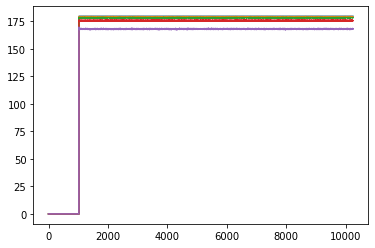

Pure Hadamard matrix algorithm. Transmission matrix entries slowly change.


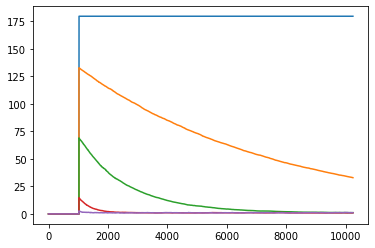

Hadamadr matrix + contineous sequential algorithm. Transmission matrix entries fluctuate around the initial positions.


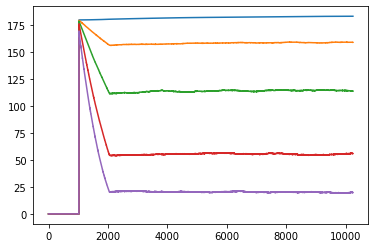

Hadamadr matrix + contineous sequential algorithm. Transmission matrix entries slowly change.


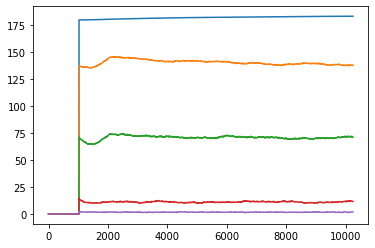

Contineous sequential algorithm. Transmission matrix entries fluctuate around the initial positions.


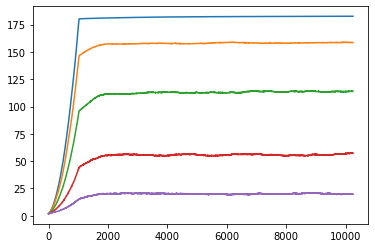

Hadamadr matrix + contineous sequential algorithm. Transmission matrix entries slowly change.


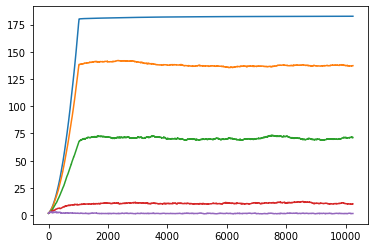

In [189]:
# Simulation parameters
slm_side = 32
slm_size = slm_side**2
total_steps = 10240
tm_vec_sigma = 1.0
e_in = 1.0 + 0.0j
use_noised_tm = False
simulations_number = 100

noise_levels = [0.0, 0.0125, 0.025, 0.05, 0.1]

# Noise functions
def add_noise_1(tm_vec):
    return tm_vec_add_noise(tm_vec, 0.0125, tm_vec_sigma)
def add_noise_2(tm_vec):
    return tm_vec_add_noise(tm_vec, 0.050, tm_vec_sigma)

# Calculate initial enhancement
samples_num = 1000000
I_init = 0.0
slm_pattern_ref = np.ones(slm_size)
for i in range(0, samples_num):
    tm_vec_temp = generate_tm_vec(tm_vec_sigma, slm_size)
    I_init += np.abs(np.dot(tm_vec_temp, slm_pattern_ref) * e_in)**2
del tm_vec_temp
I_init = I_init / samples_num / 2.0

print("Initial intensity: {0}".format(I_init))
print("Initial simulation parameters:")
print("    slm_size           = {0}".format(slm_size))
print("    total_steps        = {0}".format(total_steps))
print("    tm_vec_sigma       = {0}".format(tm_vec_sigma))
print("    e_in               = {0}".format(e_in))
print("    simulations_number = {0}".format(simulations_number))
print("    I_init             = {0}".format(I_init))

print("")

# average_enh_history_phsf = np.zeros(total_steps)
# average_enh_history_phsc = np.zeros(total_steps)
# average_enh_history_hcsasf = np.zeros(total_steps)
# average_enh_history_hcsasc = np.zeros(total_steps)
# average_enh_history_csasf = np.zeros(total_steps)
# average_enh_history_csasc = np.zeros(total_steps)
average_enh_history_phsf = []
average_enh_history_phsc = []
average_enh_history_hcsasf = []
average_enh_history_hcsasc = []
average_enh_history_csasf = []
average_enh_history_csasc = []

for i in range(0, len(noise_levels)):
    average_enh_history_phsf.append([])
    average_enh_history_phsc.append([])
    average_enh_history_hcsasf.append([])
    average_enh_history_hcsasc.append([])
    average_enh_history_csasf.append([])
    average_enh_history_csasc.append([])

for i in range (0, simulations_number):
    # Generate transmission matrix for optimization
    tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
    e_ref = np.dot(tm_vec, np.ones(slm_size)) * e_in
    align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
    tm_vec = tm_vec * align_multiplier
    
    print("Simulation iteration: {0}/{1}".format(i + 1, simulations_number))
    
    for k in range(0, len(noise_levels)):
        # Pure Hadamard matrix algorithm. Transmission matrix entries fluctuate around the initial positions.
        result = optimize_hadamard(tm_vec,
            initial_enh_history=None,
            initial_intensity=I_init,
            steps_num=total_steps,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=False,
            inc_el_field=e_in)
        # average_enh_history_phsf += result["enh_history"]
        average_enh_history_phsf[k].append(result["enh_history"])

        # Pure Hadamard matrix algorithm. Transmission matrix entries slowly change.
        result = optimize_hadamard(tm_vec,
            initial_enh_history=None,
            initial_intensity=I_init,
            steps_num=total_steps,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=True,
            inc_el_field=e_in)
        # average_enh_history_phsc += result["enh_history"]
        average_enh_history_phsc[k].append(result["enh_history"])

        # Hadamadr matrix + contineous sequential algorithm.
        # Transmission matrix entries fluctuate around the initial positions.
        result = optimize_hadamard(tm_vec,
            initial_enh_history=np.zeros(total_steps),
            initial_intensity=I_init,
            steps_num=slm_size,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=False,
            inc_el_field=e_in)
        result = optimize_csa(
            tm_vec=result["tm_vec"],
            initial_slm_pattern=result["slm_pattern"],
            initial_enh_history=result["enh_history"],
            initial_intensity=I_init,
            start_step=slm_size,
            steps_num=total_steps,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=False,
            inc_el_field=e_in)
        # average_enh_history_hcsasf += result["enh_history"]
        average_enh_history_hcsasf[k].append(result["enh_history"])

        # Hadamadr matrix + contineous sequential algorithm.
        # Transmission matrix entries slowly change.
        result = optimize_hadamard(tm_vec,
            initial_enh_history=np.zeros(total_steps),
            initial_intensity=I_init,
            steps_num=slm_size,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=True,
            inc_el_field=e_in)
        result = optimize_csa(
            tm_vec=result["tm_vec"],
            initial_slm_pattern=result["slm_pattern"],
            initial_enh_history=result["enh_history"],
            initial_intensity=I_init,
            start_step=slm_size,
            steps_num=total_steps,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=True,
            inc_el_field=e_in)
        # average_enh_history_hcsasc += result["enh_history"]
        average_enh_history_hcsasc[k].append(result["enh_history"])

        # Contineous sequential algorithm.
        # Transmission matrix entries fluctuate around the initial positions.
        result = optimize_csa(
            tm_vec=result["tm_vec"],
            initial_slm_pattern=None,
            initial_enh_history=None,
            initial_intensity=I_init,
            start_step=0,
            steps_num=total_steps,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=False,
            inc_el_field=e_in)
        # average_enh_history_csasf += result["enh_history"]
        average_enh_history_csasf[k].append(result["enh_history"])

        # Contineous sequential algorithm.
        # Transmission matrix entries slowly change.    
        result = optimize_csa(
            tm_vec=result["tm_vec"],
            initial_slm_pattern=None,
            initial_enh_history=None,
            initial_intensity=I_init,
            start_step=0,
            steps_num=total_steps,
            slm_size=slm_size,
            noise_func=lambda tm: tm_vec_add_noise(tm, noise_levels[k], tm_vec_sigma),
            use_noised_tm=True,
            inc_el_field=e_in)
        # average_enh_history_csasc += result["enh_history"]
        average_enh_history_csasc[k].append(result["enh_history"])

print("Simulation finished.")

average_enh_history_phsf_mean = []
average_enh_history_phsc_mean = []
average_enh_history_hcsasf_mean = []
average_enh_history_hcsasc_mean = []
average_enh_history_csasf_mean = []
average_enh_history_csasc_mean = []

for k in range(0, len(noise_levels)):
    average_enh_history_phsf_mean.append(np.mean(average_enh_history_phsf[k], axis=0))
    average_enh_history_phsc_mean.append(np.mean(average_enh_history_phsc[k], axis=0))
    average_enh_history_hcsasf_mean.append(np.mean(average_enh_history_hcsasf[k], axis=0))
    average_enh_history_hcsasc_mean.append(np.mean(average_enh_history_hcsasc[k], axis=0))
    average_enh_history_csasf_mean.append(np.mean(average_enh_history_csasf[k], axis=0))
    average_enh_history_csasc_mean.append(np.mean(average_enh_history_csasc[k], axis=0))

# print("Pure Hadamard matrix algorithm. Transmission matrix entries fluctuate around the initial positions.")
# average_enh_history_phsf /= simulations_number
# plt.plot(average_enh_history_phsf)
# average_enh_history_phsf_mean = np.mean(average_enh_history_phsf, axis=0)
# plt.plot(average_enh_history_phsf_mean)
# plt.show()
# print("Pure Hadamard matrix algorithm. Transmission matrix entries slowly change.")
# average_enh_history_phsc /= simulations_number
# plt.plot(average_enh_history_phsc)
# average_enh_history_phsc_mean = np.mean(average_enh_history_phsc, axis=0)
# plt.plot(average_enh_history_phsc_mean)
# plt.show()
# print("Hadamadr matrix + contineous sequential algorithm. "
#       "Transmission matrix entries fluctuate around the initial positions.")
# average_enh_history_hcsasf /= simulations_number
# plt.plot(average_enh_history_hcsasf)
# average_enh_history_hcsasf_mean = np.mean(average_enh_history_hcsasf, axis=0)
# plt.plot(average_enh_history_hcsasf_mean)
# plt.show()
# print("Hadamadr matrix + contineous sequential algorithm. "
#       "Transmission matrix entries slowly change.")
# average_enh_history_hcsasc /= simulations_number
# plt.plot(average_enh_history_hcsasc)
# average_enh_history_hcsasc_mean = np.mean(average_enh_history_hcsasc, axis=0)
# plt.plot(average_enh_history_hcsasc_mean)
# plt.show()
# print("Contineous sequential algorithm. "
#       "Transmission matrix entries fluctuate around the initial positions.")
# average_enh_history_csasf /= simulations_number
# plt.plot(average_enh_history_csasf)
# average_enh_history_csasf_mean = np.mean(average_enh_history_csasf, axis=0)
# plt.plot(average_enh_history_csasf_mean)
# plt.show()
# print("Hadamadr matrix + contineous sequential algorithm. "
#       "Transmission matrix entries slowly change.")
# average_enh_history_csasc /= simulations_number
# plt.plot(average_enh_history_csasc)
# average_enh_history_csasc_mean = np.mean(average_enh_history_csasc, axis=0)
# plt.plot(average_enh_history_csasc_mean)
# plt.show()

print("Noise levels: {0}".format(noise_levels))

print("Pure Hadamard matrix algorithm. Transmission matrix entries fluctuate around the initial positions.")
for k in range(0, len(noise_levels)):
    plt.plot(average_enh_history_phsf_mean[k])
plt.show()
print("Pure Hadamard matrix algorithm. Transmission matrix entries slowly change.")
for k in range(0, len(noise_levels)):
    plt.plot(average_enh_history_phsc_mean[k])
plt.show()
print("Hadamadr matrix + contineous sequential algorithm. "
      "Transmission matrix entries fluctuate around the initial positions.")
for k in range(0, len(noise_levels)):
    plt.plot(average_enh_history_hcsasf_mean[k])
plt.show()
print("Hadamadr matrix + contineous sequential algorithm. "
      "Transmission matrix entries slowly change.")
for k in range(0, len(noise_levels)):
    plt.plot(average_enh_history_hcsasc_mean[k])
plt.show()
print("Contineous sequential algorithm. "
      "Transmission matrix entries fluctuate around the initial positions.")
for k in range(0, len(noise_levels)):
    plt.plot(average_enh_history_csasf_mean[k])
plt.show()
print("Hadamadr matrix + contineous sequential algorithm. "
      "Transmission matrix entries slowly change.")
for k in range(0, len(noise_levels)):
    plt.plot(average_enh_history_csasc_mean[k])
plt.show()

for k in range(0, len(noise_levels)):
    with open("/Users/o.danko/Temp/enh_history_phsf_noise_{0}_{1}.csv".format(
        noise_levels[k], datetime.now().strftime("%m-%d-%Y_%H:%M:%S")), "w") as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(average_enh_history_phsf_mean[k])):
            csv_writer.writerow([i, average_enh_history_phsf_mean[k][i]])
    with open("/Users/o.danko/Temp/enh_history_phsc_noise_{0}_{1}.csv".format(
        noise_levels[k], datetime.now().strftime("%m-%d-%Y_%H:%M:%S")), "w") as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(average_enh_history_phsc_mean[k])):
            csv_writer.writerow([i, average_enh_history_phsc_mean[k][i]])
    with open("/Users/o.danko/Temp/enh_history_hcsasf_noise_{0}_{1}.csv".format(
        noise_levels[k], datetime.now().strftime("%m-%d-%Y_%H:%M:%S")), "w") as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(average_enh_history_hcsasf_mean[k])):
            csv_writer.writerow([i, average_enh_history_hcsasf_mean[k][i]])
    with open("/Users/o.danko/Temp/enh_history_hcsasc_noise_{0}_{1}.csv".format(
        noise_levels[k], datetime.now().strftime("%m-%d-%Y_%H:%M:%S")), "w") as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(average_enh_history_hcsasc_mean[k])):
            csv_writer.writerow([i, average_enh_history_hcsasc_mean[k][i]])
    with open("/Users/o.danko/Temp/enh_history_csasf_noise_{0}_{1}.csv".format(
        noise_levels[k], datetime.now().strftime("%m-%d-%Y_%H:%M:%S")), "w") as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(average_enh_history_csasf_mean[k])):
            csv_writer.writerow([i, average_enh_history_csasf_mean[k][i]])
    with open("/Users/o.danko/Temp/enh_history_csasc_noise_{0}_{1}.csv".format(
        noise_levels[k], datetime.now().strftime("%m-%d-%Y_%H:%M:%S")), "w") as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(average_enh_history_csasc_mean[k])):
            csv_writer.writerow([i, average_enh_history_csasc_mean[k][i]])

In [171]:
func = lambda tm: tm_vec_add_noise(tm, noise_levels[1], tm_vec_sigma) if noise_levels[1] != 0.0 else None

In [172]:
print(func(tm_vec))

[ 0.02514617-0.00944007j -0.01141335-0.01214497j  0.04593157-0.04333086j
 ...  0.01028992-0.01964697j -0.00172271-0.03935256j
 -0.00378157-0.01786435j]


In [188]:
average_enh_history_hcsasf[4][1][1023]

153.1055582348726